<a href="https://colab.research.google.com/github/Vlada1356277/ML/blob/main/%D0%94%D0%97_2/%D0%A1%D0%B8%D0%BD%D1%82%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Импорт библиотек***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### ***Генерация Данных***

In [2]:
# функуция создания одномерных данных, которые могут быть некоторыми функциями от входных данных X
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:] # преобразуем данные в массив
    a = np.atleast_1d(a) # преобразуем данные в массив
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

# функция добавления шумов 
def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

# обЪеденим  все это  в функции dataset 
def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [3]:
# создадим функцию для визуализации данных
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()

***Линейная зависимость***

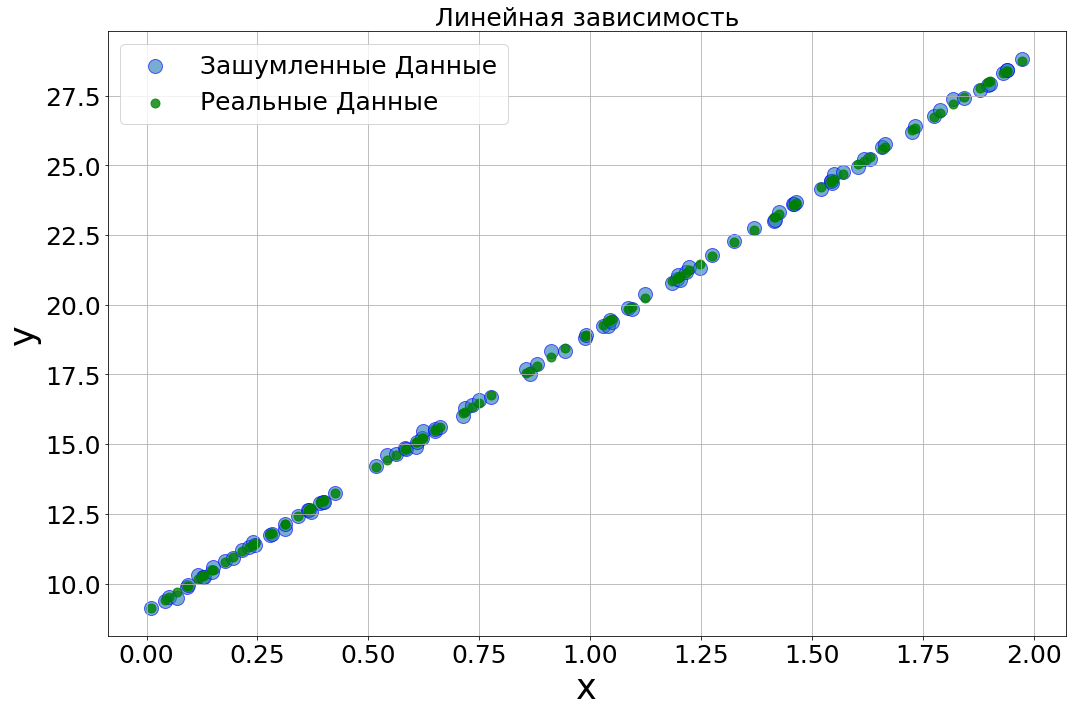

In [4]:
noise_power = 0.1 # шум

# зададаим данным линейную зависимость
y, y_true, x = dataset(a = 10, b = 9,
                       f = None,  N = 100,
                       x_max =2, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')

# y = 10x + 9


### ***Линейная регрессия***


In [6]:
# выделение тестовой и тренировочной выборки из входных данных
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()

x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(70, 1) (70,) (30, 1) (30,)


***Функция инициализации весовых параметров. Создается случайный массив весовых параметров***

In [8]:
def init_weights(W_shape, add_bias = True, random_state = 42):
    # создадим случайный массив весовых параметров с нормальным распределением
    W_shape = np.atleast_1d(W_shape)
    if random_state: 
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape)) 
    # набор весов с учетом смещения   
    if add_bias: 
        W = np.column_stack((np.zeros(W.shape[-1]),W ))
    return W.squeeze()



***Функции предсказания и расчета значений функции потерь. Для учета смещения будем добавлять единичный столбец к входным данным***

In [9]:
def predict( X, W, add_bias = True):
  # зададим возможность добавлять или нет в модель независимый коэффициент с помощью булевой переменной add_bias
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return  np.dot(X_full,W)

# функция потерь
def loss_func(yhat, y):
    return np.square(yhat - y)  

***Протестируем функции***

In [10]:
x_train[:1]

array([[1.6167947]])

In [11]:
# инициализируем веса и протестируем модель для первой строчки данных
weights = init_weights(x.shape[1])
yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y[0])

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}')


[0.         0.49671415]
predict [0.80308481],
ground truth [9.11914705],
loss: [69.1568912]


***Посмотрим на график того как меняется функция потерь в зависимости от отклонения (мультипликативного) оценки результата от его истинного значения.***

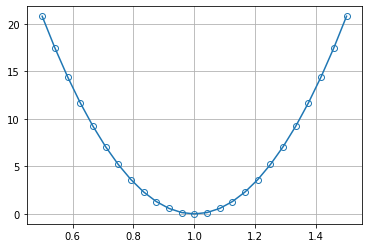

In [12]:
decline = np.linspace(start = 0.5, stop = 1.5,num = 25)
yhat = decline* y[0]
loss = loss_func(yhat, y[0])
plt.plot(decline,loss,'-o', mfc = 'none'); plt.grid(); 

In [13]:
# функция оптимизациии весов с помощью градиентного спуска 
def grad_loss(y_hat, y, X, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return 2*np.dot(X_full.T, (y_hat - y)) / y.size

***Проведем расчет градиента ошибки***

In [ ]:
yhat = predict(x_train[0], weights)

grad = grad_loss(yhat, y[0], x[0])
print(grad)

In [15]:
# фуекция обновления весов
def update_weights(grad, W, learning_rate):
    return W - learning_rate*grad

***Проведем обновление весовых параметров***

In [16]:
lerning_rate = 0.1
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[1.66321245 0.51508306]


In [17]:
yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y[0])

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}')

[1.66321245 0.51508306]
predict [2.49599601],
ground truth [9.11914705],
loss: [43.8661297]


***Создадим процедуру обучения. Процедура будет повторять порцесс пересчета весов методом градиентного спуска заданое число раз (epochs)***

In [18]:
# Создадим функцию итерационного обучения
def fit(X, y, learning_rate, weights = None,  epochs=30):

    if weights is None: weights = init_weights(X.shape[1])
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        yhat    = predict(X,weights)
        grad    = grad_loss(yhat,  y, X) 
        weights = update_weights(grad, weights, lerning_rate)  
        cost[i] = loss_func(yhat,  y).mean()
                
    return weights, cost


***Протестируем обучение***

In [19]:
weights, cost = fit(x_train, y_train, learning_rate=0.1, epochs=10)

In [20]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks(FontSize = 25)

    plt.yticks(FontSize = 25);  


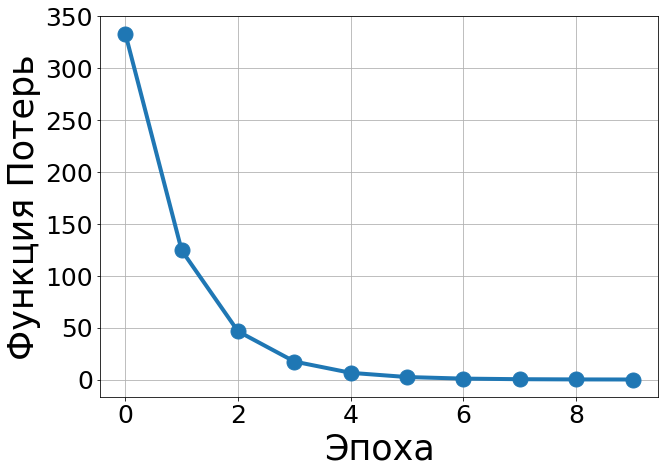

In [21]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)


***Проверим, как точно предсказывает наша функция***

In [22]:
# Коэффициент детерминации
def r2_score(yhat, y):    
    return 1-(np.square(y-yhat)).sum(axis=0)/(np.square(y-np.mean(y, axis=0))).sum(axis=0)

In [23]:
predicts = predict( x_test,weights,)

r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

(0.9992385801657113, 0.9992626778344069)

***Посмотрим на то, какая интерпретация может быть у предсказанных и заданных данных***

In [24]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.plot(x_train[:,0], predict(x_train,weights, ),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], predict(x_test,weights, ),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);


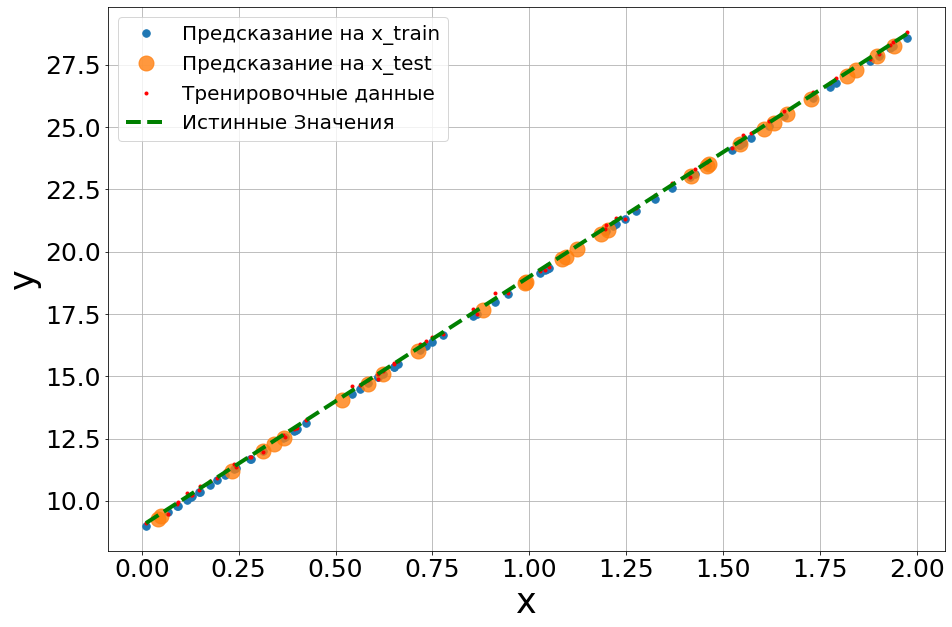

In [25]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

In [26]:
weights

array([8.87861174, 9.98961201])

In [30]:
# визуализируем веса
def vis_weigths(weights):
    numbers = np.arange(0,len(weights))
    tick_labels = ['w'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels );
  

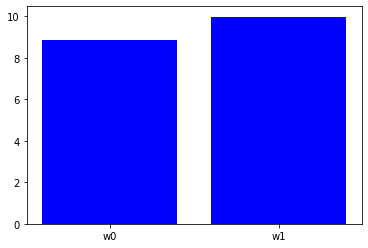

In [31]:
vis_weigths(weights)

In [32]:
# Функция для генерации батчей заданного размера batch_size
def load_batch(X,y, batch_size = 100):
    idxs = np.arange(y.size)
    np.random.shuffle(idxs)

    for i_batch in range(0,y.size,batch_size):
        idx_batch = idxs[i_batch:i_batch+batch_size]
        x_batch   = np.take(X, idx_batch,axis=0)
        y_batch   = np.take(y, idx_batch)
        yield  x_batch, y_batch

In [33]:
# Обновим функцию fit с учетом разбиения данных на батчи.
BATCH = 10

def fit_SGD(X, y, lerning_rate, weights = None,  epochs=30, batch_size = 100, random_state = 42):
    
    if random_state: np.random.seed(random_state)

    if weights is None: weights = init_weights(X.shape[1])
    if batch_size is None or batch_size>y.size : batch_size = y.size
    n_batches = y.size//batch_size
    
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        loss = 0
        for cnt,(x_batch, y_batch) in enumerate(load_batch(X,y, batch_size)): 

            yhat    = predict(x_batch, weights)
            grad    = grad_loss(yhat,  y_batch, x_batch) 
            weights = update_weights(grad, weights, lerning_rate) #backward 
            loss   += loss_func(yhat,  y_batch).mean()

            if cnt>= n_batches:
                break
        cost[i] = loss/n_batches

    return weights, cost

In [34]:
weights = init_weights(x_train.shape[1], random_state=42)

weights, cost = fit_SGD(x_train, y_train, lerning_rate=0.1, batch_size = 10,  epochs=10)

predicts = predict(x_test, weights, )
r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)


(0.9997385011115064, 0.9997666061557021)

In [35]:
weights

array([ 9.00580885, 10.00186475])

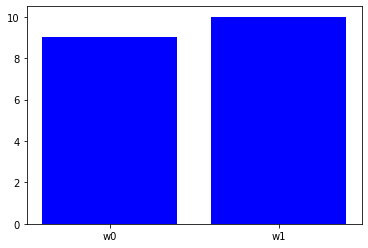

In [36]:
vis_weigths(weights)

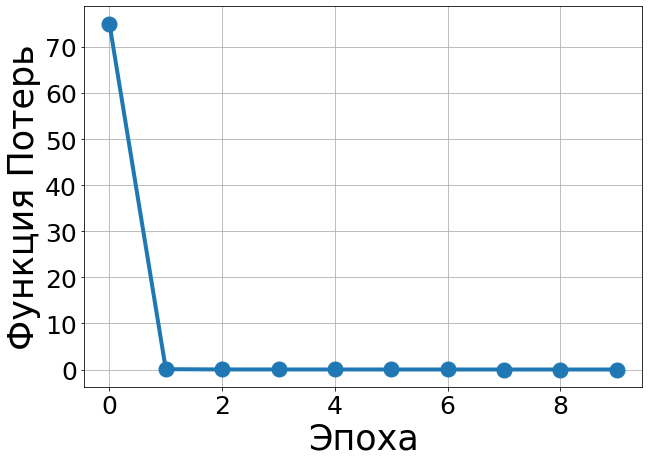

In [37]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)

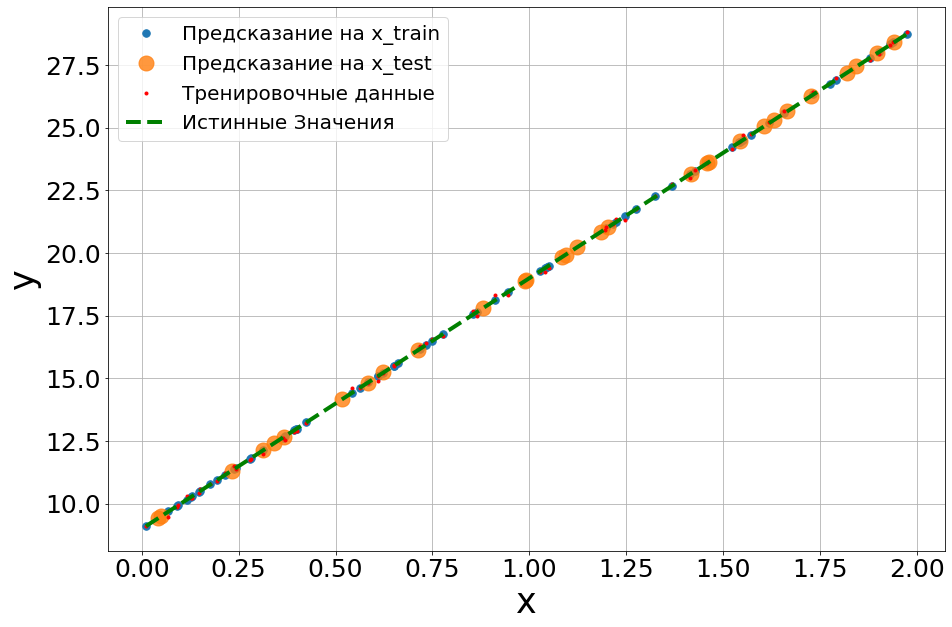

In [38]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

*работает лучше, чем было*

***Объеденим все в один класс линейной регресии.***

In [41]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)
        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
  #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)


## **Полиномиальная Зависимость**

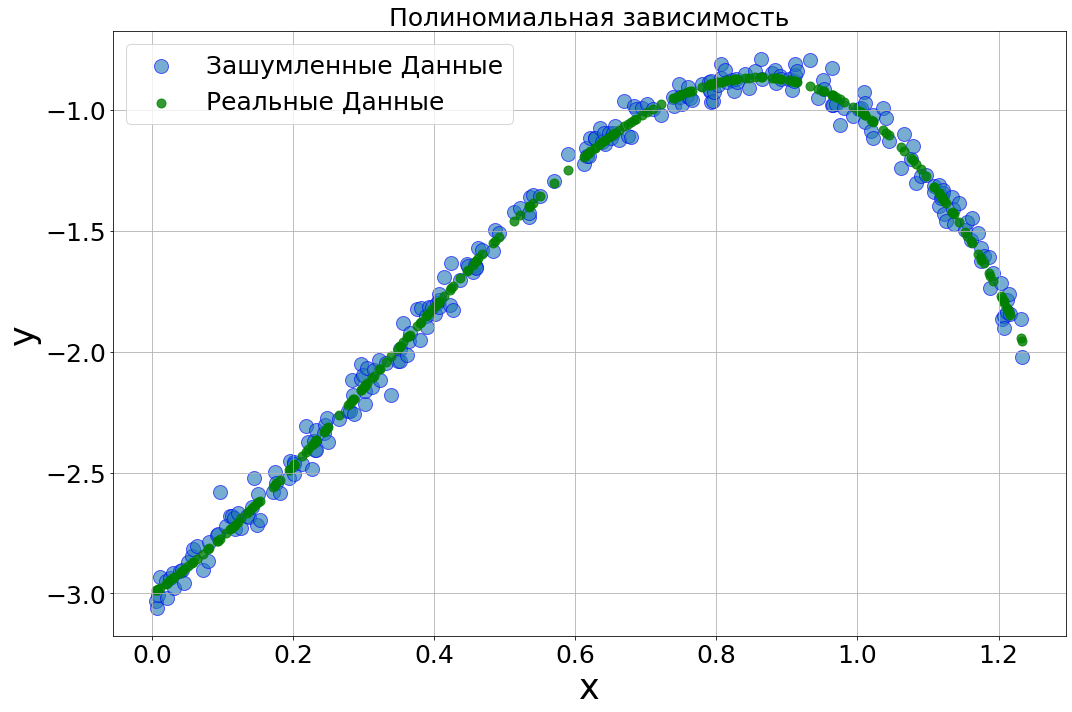

In [62]:
noise_power = 0.05

y, y_true, x = dataset(a = [2,4,-4], b =-3,
                       f = None,  N = 250,
                       x_max =1.25, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

#y = -4x^3 + 4x^2 + 2x - 3

In [64]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )

In [65]:
regr_poly_lin = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
regr_poly_lin.fit(x_train, y_train)

In [66]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);


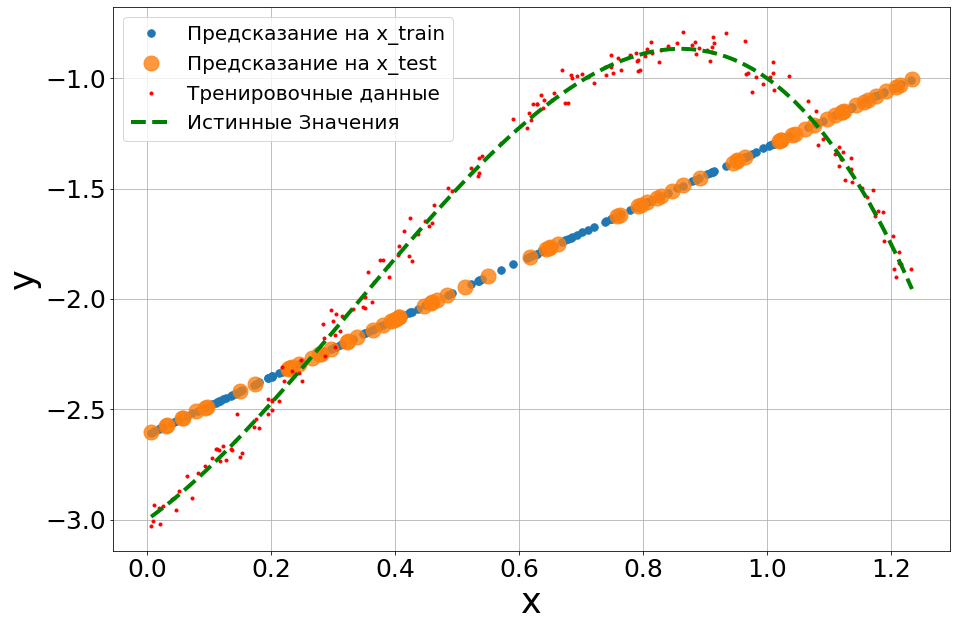

In [67]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly_lin)

***работает не очень хорошо***

In [68]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T

In [69]:
x_ = to_polynom(x, order = 3) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3, )

In [70]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)


In [71]:
regr_poly.fit(x_train, y_train)

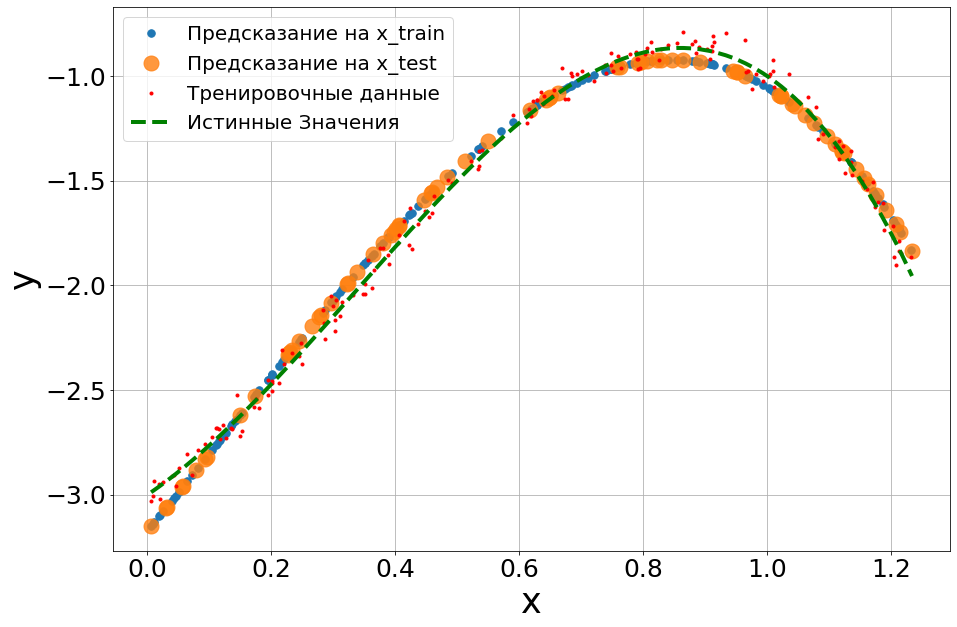

In [72]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)

стало намного лучше благодаря полиному 3 степени

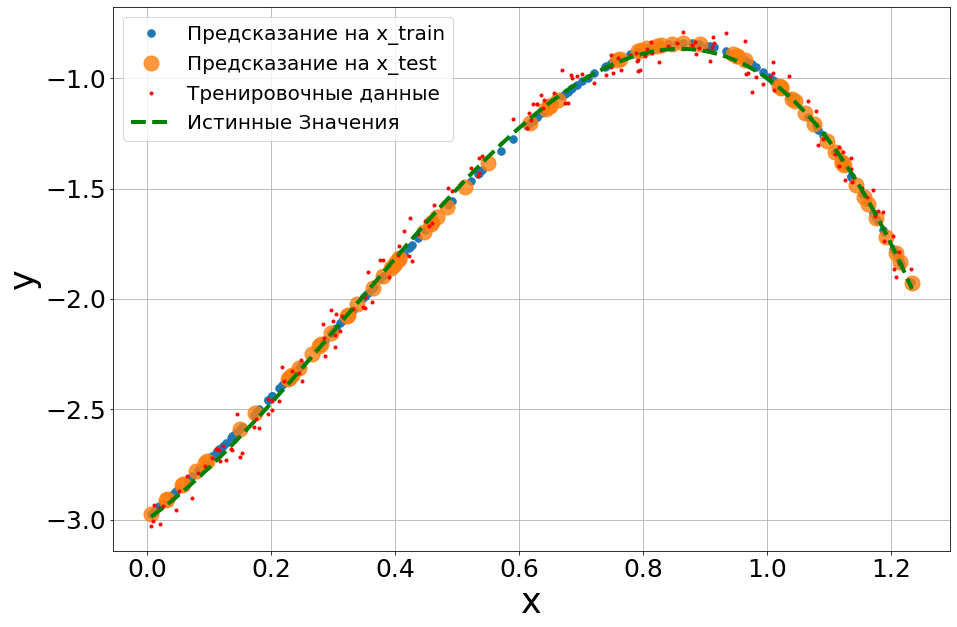

In [73]:
x_ = to_polynom(x, order = 8) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3, )

regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

regr_poly.fit(x_train, y_train)

fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)


теперь совсем хорошо

### ***Гармоническая зависимость***

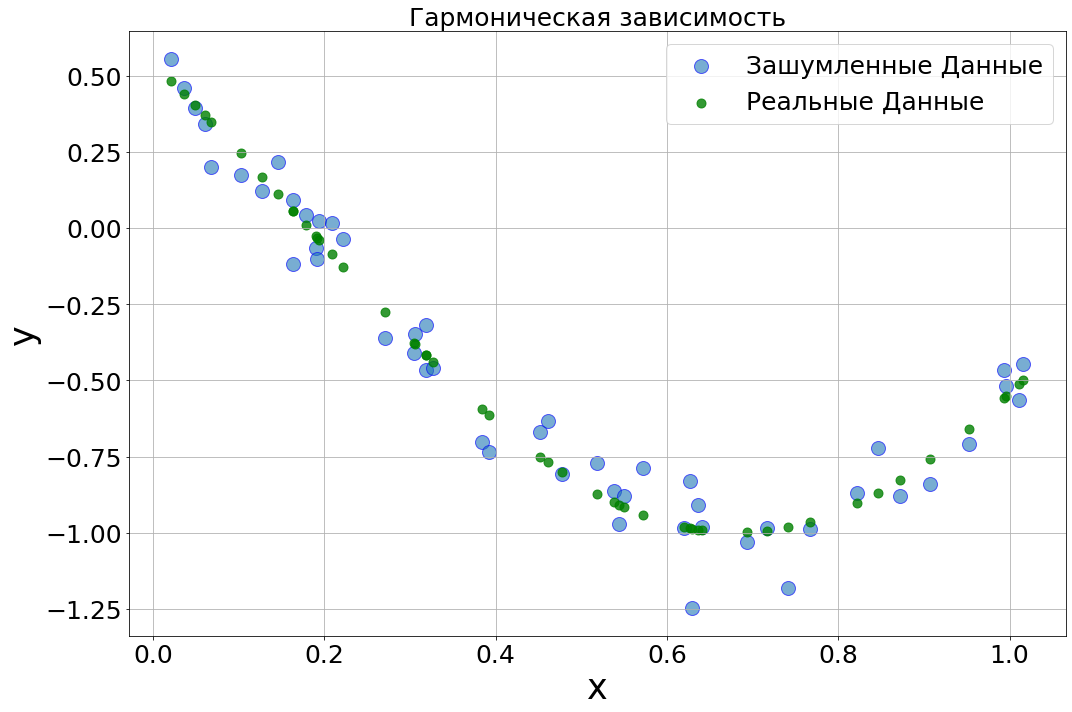

In [74]:
y, y_true, x = dataset(a = np.pi,
                       b = 1, f = np.cos,  
                       N = 50, x_max =np.pi/3, 
                       noise_power = 0.1, seed = 42)
vis_data(y, y_true,x, 'Гармоническая зависимость')

In [75]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(35, 1) (35,) (15, 1) (15,)


Train Score = 0.58


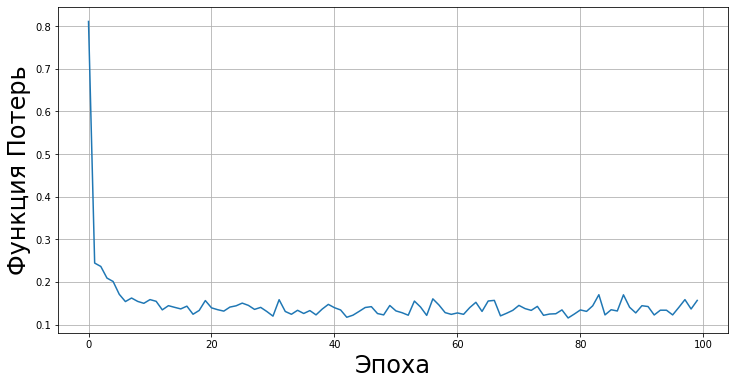

In [76]:
regr_harm = LinearRegression(learning_rate=0.25,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_harm.fit(x_train, y_train)

print(f'Train Score = {regr_harm.score(x_train, y_train):.2f}')
regr_harm.plot_cost()

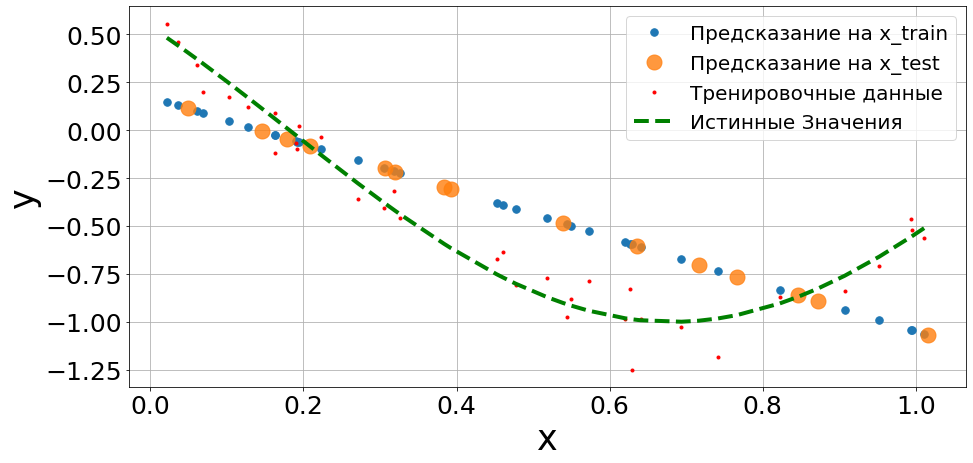

In [77]:
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_harm)

работает плохо

In [78]:
w, b = regr_harm.get_w_and_b()
print(w,b)


[-1.22439887] 0.1747622161632973


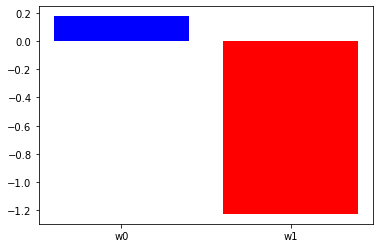

In [79]:
vis_weigths(np.hstack([b,w]))


### ***Полиномиальная регрессия для гармонических данных***

In [80]:
order  = 10 # создаем набор данных

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)

pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9
31,0.190407,0.036255,0.006903,0.001314,2.502711e-04,4.765328e-05,9.073502e-06,1.727655e-06,3.289571e-07,6.263562e-08
32,0.640731,0.410536,0.263043,0.168540,1.079887e-01,6.919167e-02,4.433324e-02,2.840567e-02,1.820039e-02,1.166155e-02
33,0.036012,0.001297,0.000047,0.000002,6.056345e-08,2.180985e-09,7.854071e-11,2.828375e-12,1.018542e-13,3.667931e-15
34,0.326423,0.106552,0.034781,0.011353,3.705990e-03,1.209721e-03,3.948808e-04,1.288982e-04,4.207534e-05,1.373436e-05


Test Score = 0.72, Train Score = 0.73


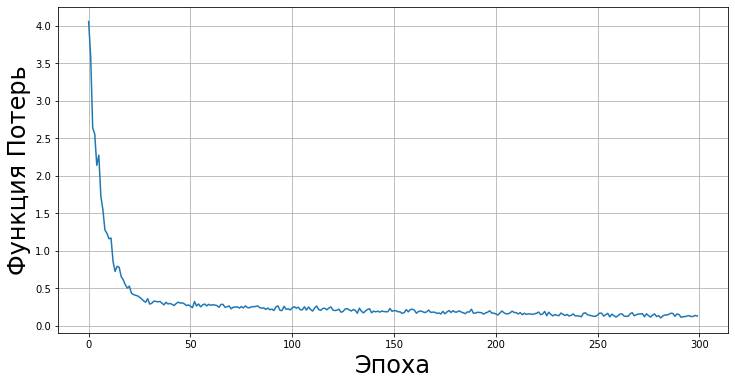

In [81]:
regr_harm_poly = LinearRegression(learning_rate=0.01,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly.fit(x_train_, y_train)
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()

In [82]:
w, b = regr_harm_poly.get_w_and_b()
print(w,b)

[-0.74364649 -0.61499276 -0.13157122  0.29199644 -0.17183073 -0.11316027
  0.4986437   0.26764316 -0.10587153  0.22653447] -0.03738762656853882


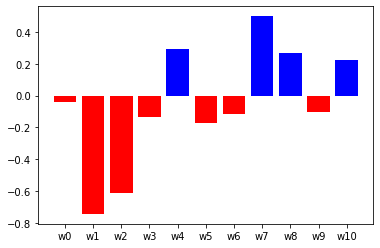

In [83]:
vis_weigths(np.hstack([b,w]))

In [84]:
np.sum(np.abs(w))

3.165890748982122

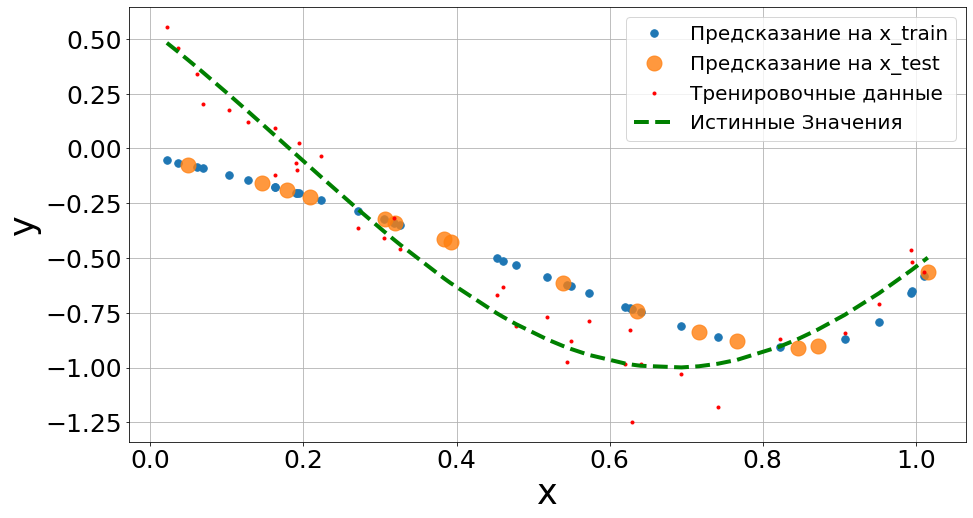

In [85]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_harm_poly)

попробуем увеличить степень

In [86]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [87]:
class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [88]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)


Test Score = 0.94, Train Score = 0.96


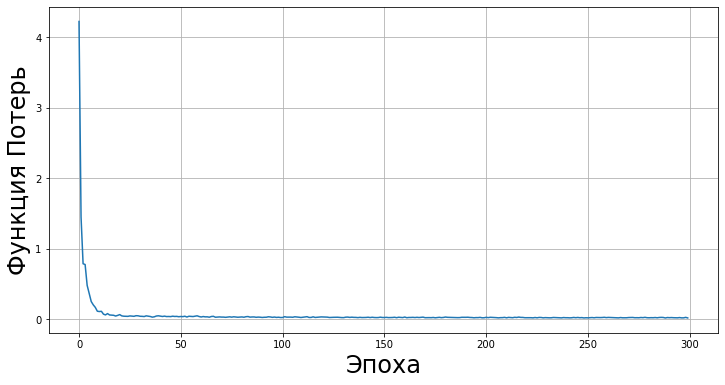

In [89]:
regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

In [91]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[-0.7037233  -0.30090408  0.16757103  0.50565427 -0.05592375 -0.09081042
  0.43572327  0.1281078  -0.31405235 -0.04323491] -0.44615251251965565


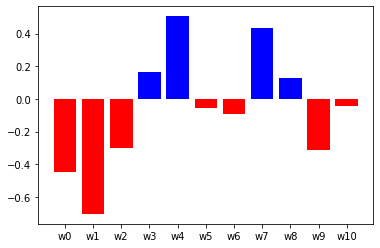

In [92]:
vis_weigths(np.hstack([b,w]))

In [93]:
np.sum(np.abs(w))

2.7457051817954374

***Посмотрим на результат***

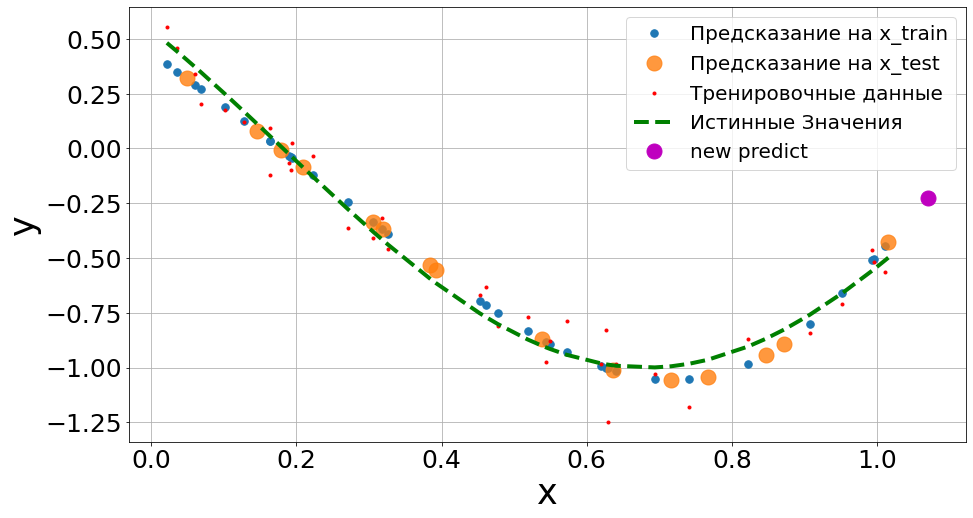

In [94]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'new predict',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);


***Метод Наименьших Квадратов***

In [101]:
order = 10
x_train_ls = to_polynom(x_train, order=order, add_bias=True)
x_test_ls  = to_polynom(x_test,  order=order, add_bias=True)
weights  = np.linalg.lstsq(x_train_ls, y_train, rcond=None)[0] #including bias

weights

array([ 6.70334957e-01, -3.69748038e+00, -1.17320109e+02,  1.99578309e+03,
       -1.40854895e+04,  5.41444895e+04, -1.24089877e+05,  1.74286141e+05,
       -1.47151273e+05,  6.85831567e+04, -1.35631015e+04])

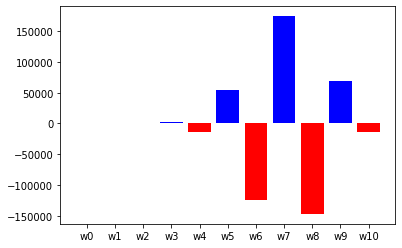

In [102]:
vis_weigths(weights)

In [103]:
np.sum(np.abs(weights))

598020.9988180357

In [104]:
def polyval(x,weights):
    return np.sum([np.power(x,i)*wi for i, wi in enumerate(weights) ],axis = 0) # including bias!

In [105]:
print(f"Test score: {r2_score(y_test, polyval(x_test,weights).squeeze()):.2f}, Train score: {r2_score(y_train, polyval(x_train,weights).squeeze()):.2f}")


Test score: 0.94, Train score: 0.97


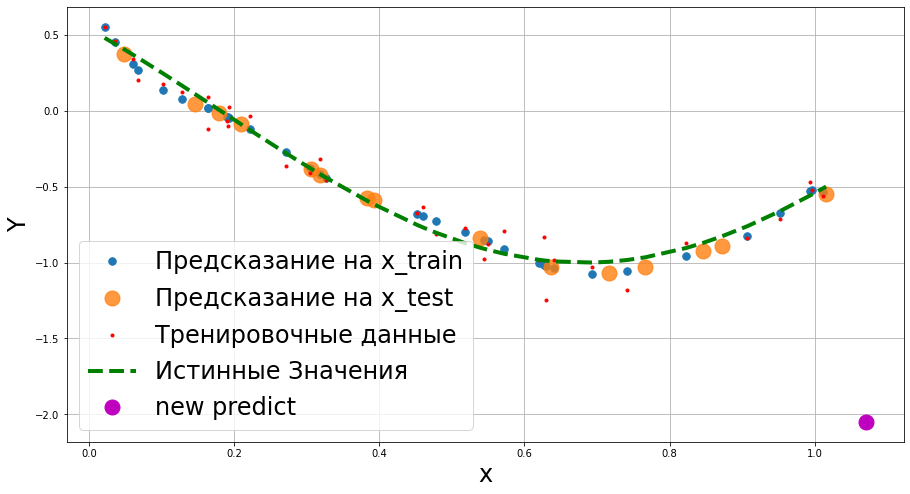

In [106]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], polyval(x_train, weights),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], polyval(x_test, weights),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         polyval([1.07], weights), 
         'mo',  label = 'new predict',
        markersize = 15 )

plt.grid()
plt.legend(fontsize = 24)
plt.xlabel('x', fontsize = 24)
plt.ylabel('Y', fontsize = 24)
plt.show()

лучше!

### ***Регуляризация линейной регрессии***

***Регуляризация Тихонова***

In [107]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  

Test Score = 0.94, Train Score = 0.96


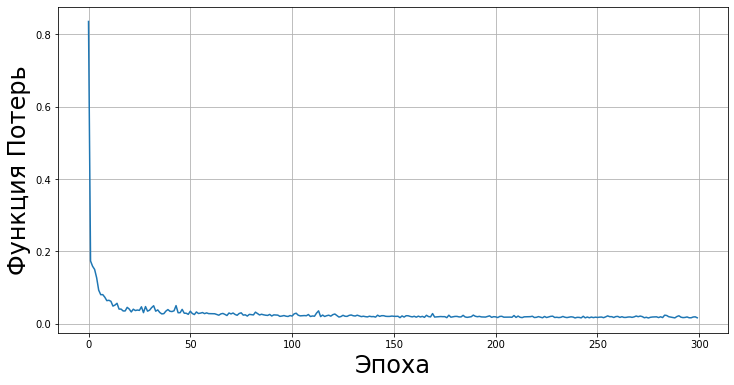

In [108]:
regr_l2 = RidgeRegression(learning_rate=0.25,
                       epochs=300, batch_size=10,
                       l2_penalty = 0.001)
regr_l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l2.score(x_test_, y_test):.2f}, Train Score = {regr_l2.score(x_train_, y_train):.2f}')
regr_l2.plot_cost()

In [109]:
w, b = regr_l2.get_w_and_b()
print(w,b)


[-2.39990683 -0.61649824  0.43427266  0.93557183  0.35605373  0.22577489
  0.62617635  0.183545   -0.39221703 -0.24893557] 0.45623526396005354


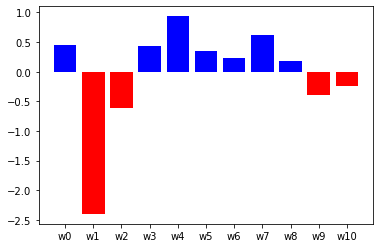

In [110]:
vis_weigths(np.hstack([b,w]))

In [111]:
np.sum(np.abs(w))

6.418952134176184

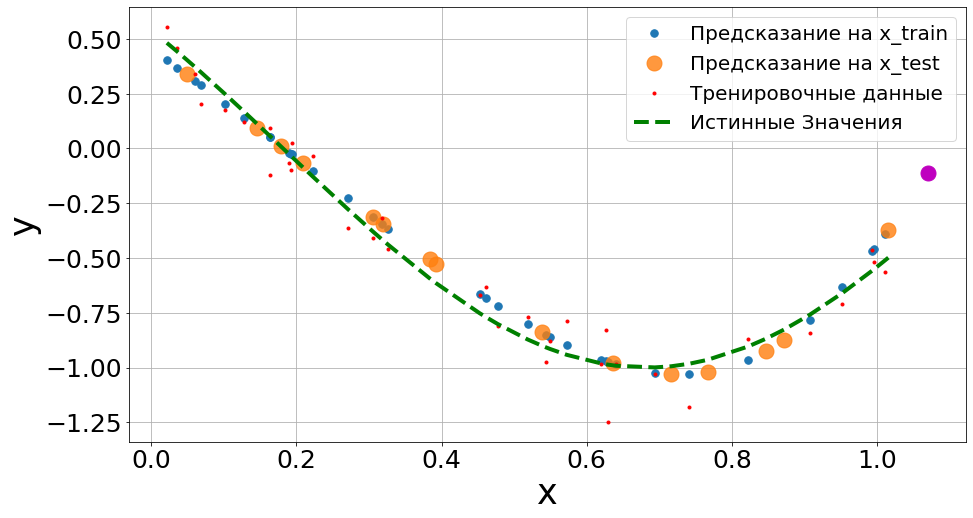

In [112]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l2)

plt.plot([1.07], 
         regr_l2.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );


### ***Регуляризация L1***

In [113]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term
                  
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)


Test Score = 0.88, Train Score = 0.95


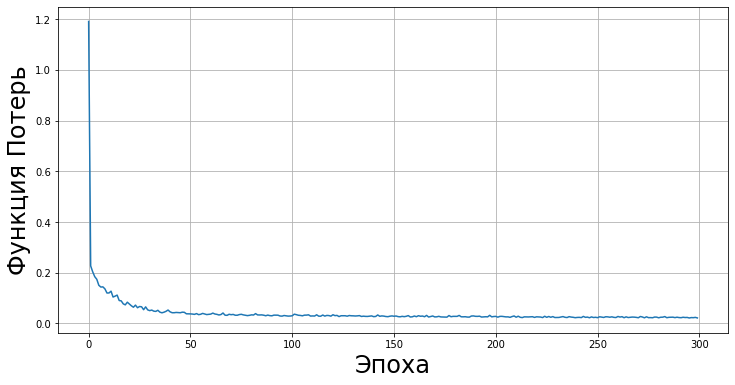

In [114]:
regr_l1 = LassoRegression(learning_rate=0.1,
                       epochs=300,batch_size=10,
                       l1_penalty = 0.001)
regr_l1.fit(x_train_, y_train)

print(f'Test Score = {regr_l1.score(x_test_, y_test):.2f}, Train Score = {regr_l1.score(x_train_, y_train):.2f}')
regr_l1.plot_cost()

In [115]:
w, b = regr_l1.get_w_and_b()
print(w,b)


[-1.95470257 -0.72783915  0.13339003  0.57893037  0.17212001  0.12837047
  0.60634479  0.26579698 -0.04437271  0.01189621] 0.36535346116646594


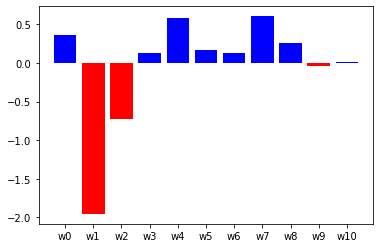

In [116]:
vis_weigths(np.hstack([b,w]))

In [117]:
np.sum(np.abs(w))

4.623763286433312

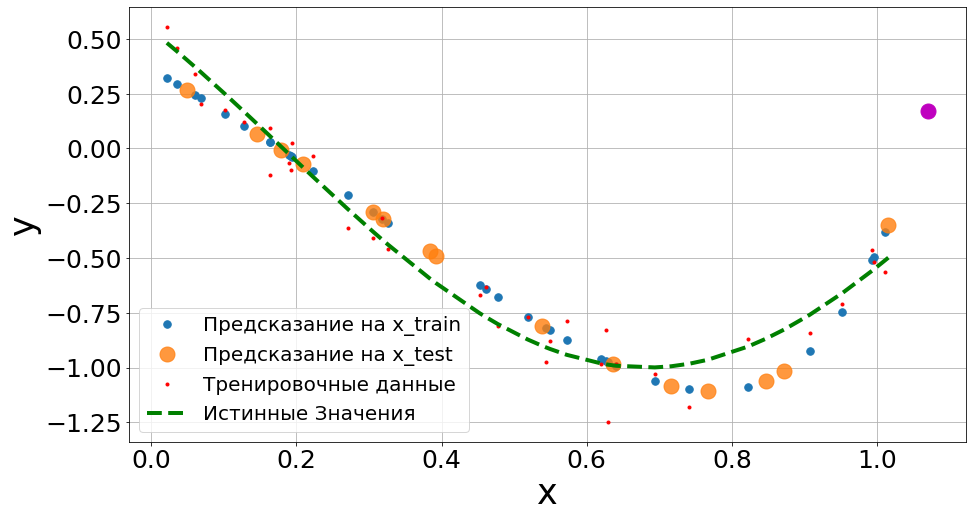

In [118]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1)

plt.plot([1.07], 
         regr_l1.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

### *Эластичная регуляризация*

In [119]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

Test Score = 0.88, Train Score = 0.95


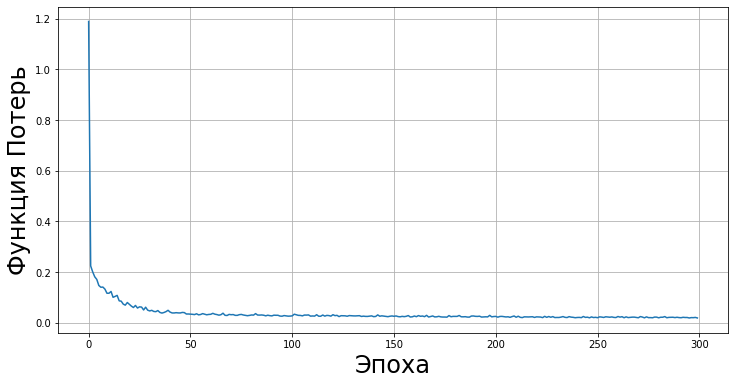

In [120]:
regr_l1l2 = ElasticRegression(learning_rate=0.1,
                         epochs=300,batch_size=10,
                         l1_penalty = 0.0001,l2_penalty = 0.001 )
regr_l1l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l1l2.score(x_test_, y_test):.2f}, Train Score = {regr_l1l2.score(x_train_, y_train):.2f}')
regr_l1l2.plot_cost()


In [121]:
w, b = regr_l1l2.get_w_and_b()
print(w,b)

[-1.96425808 -0.78430043  0.1334476   0.65932289  0.17735991  0.14466513
  0.6426251   0.29595498 -0.17234123  0.03500795] 0.3725653384015094


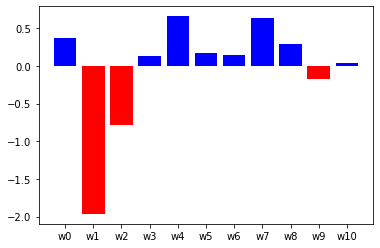

In [122]:
vis_weigths(np.hstack([b,w]))

In [123]:
np.sum(np.abs(w))

5.0092832969690795

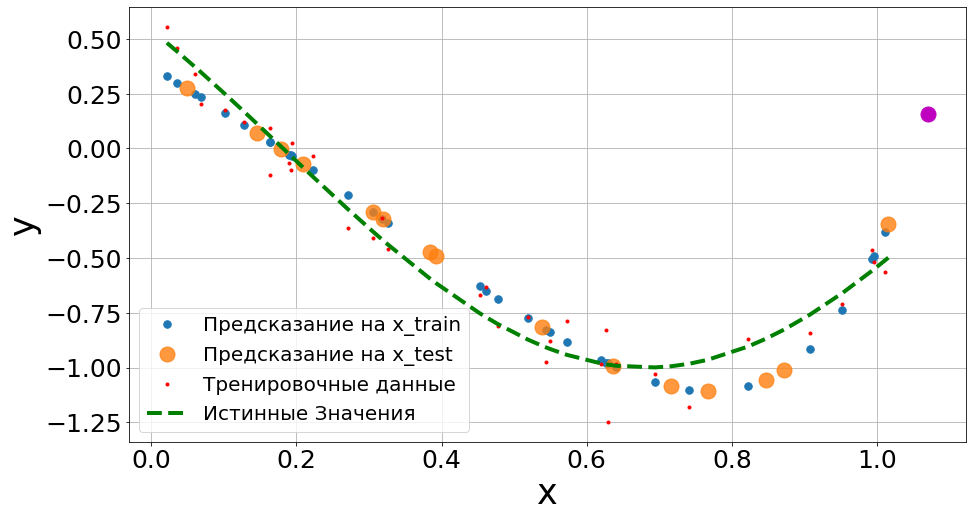

In [124]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1l2)

plt.plot([1.07], 
         regr_l1l2.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );